In [1]:
import os
import sys
import argparse
import tensorflow as tf
import numpy as np

sys.path.append('libs')
from config import Config
import utils
import model as modellib
import visualize
from model import log
from edgelist_utils import refine_mask_with_edgelist
from SketchDataset import SketchDataset

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

In [3]:
class SketchInferConfig(Config):
    # Give the configuration a recognizable name
    NAME = "sketchyscene"

    # Train on 1 GPU and 16 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 16 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # background + 46 classes

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True

    # image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768

    # anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # use the binary input to filter the pred_mask if 'True'
    IGNORE_BG = True

In [4]:
arr = {'data_base_dir': '../data','dataset_type': 'val','image_id': 2, 'epochs': '0100', 'use_edgelist': 0}
data_base_dir = arr['data_base_dir']
dataset_type = arr['dataset_type']
image_id = arr['image_id']
epochs = arr['epochs']
use_edgelist = arr['use_edgelist']
outputs_base_dir = 'outputs'

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
def segment_inference(original_image):
    vis_result_save_dir = os.path.join(outputs_base_dir, 'visual_result', dataset_type)
    trained_model_dir = os.path.join(outputs_base_dir, 'snapshot')
    edgelist_result_dir = os.path.join(outputs_base_dir, 'edgelist')
    model_path = os.path.join(trained_model_dir, 'mask_rcnn_sketchyscene_' + epochs + '.h5')
    #print(model_path, "model_path")
    os.makedirs(vis_result_save_dir, exist_ok=True)
    config = SketchInferConfig()
    #config.display()

    # val/test dataset
    #dataset_infer = SketchDataset(data_base_dir)
   # dataset_infer.load_sketches(dataset_type)
   # dataset_infer.prepare()

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir='', log_dir='')

    # Load trained weights (fill in path to trained weights here)
    assert model_path != "", "Provide path to trained weights"
    #print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

    #original_image, _, gt_class_id, gt_bbox, gt_mask, _ = \
      #  modellib.load_image_gt(dataset_infer, config, image_id - 1, use_mini_mask=False)

    #log("original_image", original_image)
    #log("gt_class_id", gt_class_id)
    #log("gt_bbox", gt_bbox)
    #log("gt_mask", gt_mask)
    
    #print(gt_class_id.shape)
    #print(gt_bbox.shape)
    #print(gt_mask.shape)
    
    #gt_seg_path = os.path.join(vis_result_save_dir, str(image_id) + '_gt.png')
    
    #Visualizing ground truth
    #visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                #dataset_infer.class_names, title='Ground-Truth',
                                #save_path=gt_seg_path, fix_color=True)

    ## inference
    results = model.detect([original_image], verbose=1)
    #print(type(original_image))
    r = results[0]
    pred_boxes = r["rois"]  # (nRoIs, (y1, x1, y2, x2))
    print(pred_boxes)
    pred_class_ids = r["class_ids"]  # (nRoIs)
    pred_scores = r["scores"]  # (nRoIs)
    pred_masks = r["masks"]  # (768, 768, nRoIs)
    #log("pred_boxes", pred_boxes)
    #log("pred_masks", pred_masks)

    #if config.IGNORE_BG:
        # Use original_image(768, 768, 3) {0, 255} to filter pred_masks
        #pred_masks = np.transpose(pred_masks, (2, 0, 1))  # (nRoIs, 768, 768)
       # bin_input = original_image[:, :, 0] == 255
       # pred_masks[:, bin_input[:, :]] = 0  # (nRoIs, 768, 768)
       # pred_masks = np.transpose(pred_masks, (1, 2, 0))  # (768, 768, nRoIs)

    # refine pred_masks(768, 768, nRoIs) with edge-list
    if use_edgelist:
        refined_pred_masks = \
            refine_mask_with_edgelist(image_id, dataset_type, data_base_dir, edgelist_result_dir,
                                     pred_masks.copy(), pred_boxes)

    # caculating AP
    #iou_thresholds = np.linspace(.5, 0.95, np.round((0.95 - .5) / .05) + 1, endpoint=True)
    #APs = np.zeros([len(iou_thresholds)], dtype=np.float32)
    #APs_edg = np.zeros([len(iou_thresholds)], dtype=np.float32)
    #for i in range(len(iou_thresholds)):
        #iouThr = iou_thresholds[i]
    #    AP, precisions, recalls, overlaps = \
      #      utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
       #                      pred_boxes, pred_class_ids, pred_scores, pred_masks,
       #                      iou_threshold=iouThr)
       # APs[i] = AP

      #  if use_edgelist:
        #    AP_edg, precisions, recalls, overlaps = \
        #        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
          #                       pred_boxes, pred_class_ids, pred_scores, refined_pred_masks,
           #                      iou_threshold=iouThr)
            #APs_edg[i] = AP_edg

    #mAP = np.mean(APs)
   # mAP_edg = np.mean(APs_edg)
    #print('APs', APs)
   # print('mAP', mAP)
    #print('APs_edg', APs_edg)
    #print('mAP_edg', mAP_edg)

    # save visual results
    #visual_seg_path = os.path.join(vis_result_save_dir, str(image_id) + '_seg.png')
    #visualize.display_instances(original_image, pred_boxes, pred_masks, pred_class_ids,
                                #dataset_infer.class_names, pred_scores, title='Normal result',
                               # save_path=visual_seg_path, fix_color=True)

    if use_edgelist:
        visual_seg_edg_path = os.path.join(vis_result_save_dir, str(image_id) + '_seg_edgelist.png')
        visualize.display_instances(original_image, pred_boxes, refined_pred_masks, pred_class_ids,
                                    dataset_infer.class_names, pred_scores, title='Result with edgelist',
                                    save_path=visual_seg_edg_path, fix_color=True)
    return pred_boxes

In [7]:
#segment_inference()

## Building 2 object dataset

In [8]:
from pathlib import Path
from fastai.vision import *
import cv2
import wget
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['__version__', 'random', 'subplots', 'array', 'copy', 'partition', 'uniform', 'pad']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
data = ['house', 'mountain', 'fence', 'sun', 'bird']
#for item in data:
   # if not os.path.exists(item + '.npy'):
      #  url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' +item +'.npy'
      #  wget.download(url)

In [10]:
path=Path('../data')

In [11]:
all_data = []
for type in data:
    data_file = type + '.npy'
    all_data.append(np.load(path/data_file))

In [12]:
start = 0
num_examples = 100
label_df=[]
image_df = np.zeros((num_examples,768,768,3))
flat_img_df = np.zeros((num_examples,768,768,1))

while start < num_examples :
    two_classes = np.sort(np.random.choice(range(5), 2))
    temp1 = all_data[two_classes[0]]
    temp2 = all_data[two_classes[1]]
            
    img_generated = np.zeros((768,768)) #A big canvas
    
    random_index = np.random.randint(0,10000)
    pic_1 = temp1[random_index,:]

    random_index = np.random.randint(0,10000)
    pic_2 = temp2[random_index,:]
    pic_1 = cv2.resize(pic_1.reshape(28,28),(384,384))
    pic_2 = cv2.resize(pic_2.reshape(28,28),(384,384))
    random_chance = np.random.randint(0,2)
    if(random_chance == 0):
        img_generated[192:192+384,0:384] = pic_1.reshape(384,384)
        img_generated[192:192+384,384:768] = pic_2.reshape(384,384)
    else:
        img_generated[192:192+384,0:384]  = pic_2.reshape(384,384)
        img_generated[192:192+384,384:768] = pic_1.reshape(384,384)
    flat_img_df[start] = img_generated.reshape(768,768,1)
    an_image = np.reshape(img_generated, (768, 768,-1))
    an_image = np.broadcast_to(an_image,(768,768,3))
    #hist(an_image.ravel(), 100);
    #grid(1)
    #plt.show()
    cv2.imwrite(str(start)+'.png', an_image)
    image_df[start] = an_image
    
    label_df.append(str(two_classes[0])+str(two_classes[1]))
    start += 1

In [13]:
image_df.shape

(100, 768, 768, 3)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use `tf.cast` instead.
Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 55)               min:    0.00000  max:  768.00000
[[217  19 513 323]]
Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 55)               min:    0.00000  max:  768.00

InternalError: 2 root error(s) found.
  (0) Internal: Dst tensor is not initialized.
	 [[{{node _arg_Placeholder_3418_0_658}}]]
	 [[Assign_3421/_14335]]
  (1) Internal: Dst tensor is not initialized.
	 [[{{node _arg_Placeholder_3418_0_658}}]]
0 successful operations.
0 derived errors ignored.

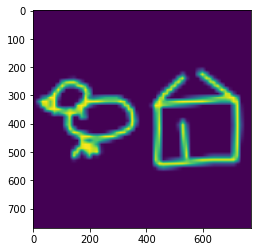

In [14]:
for z in range(100):
    test_image_index = z
    imshow(flat_img_df[test_image_index].reshape(768,768))
    boxes = segment_inference(image_df[test_image_index])
    if(len(boxes) > 1):
        for i in boxes:
            imshow(flat_img_df[test_image_index].reshape(768,768)[i[0]:i[2],i[1]:i[3]])
            plt.show()